In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pickle
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from sympy.physics.wigner import wigner_3j, wigner_6j

sys.path.append('./molecular-state-classes-and-functions/')
from classes import UncoupledBasisState, CoupledBasisState, State

In [3]:
from functions import find_state_idx_from_state, make_transform_matrix
from functions import make_hamiltonian, make_hamiltonian_B, make_QN, ni_range, vector_to_state, matrix_to_states
from state_functions import find_exact_states, calculate_BR
from hamiltonian_functions import reduced_basis_hamiltonian
from laser_functions import optical_coupling_matrix, ED_ME_mixed_state, calculate_power_needed, laser_field
from collapse_functions import collapse_matrices
from density_functions import generate_density_matrix

## X State Hamiltonian

In [4]:
H_X_uc = make_hamiltonian("./stored_data/TlF_X_state_hamiltonian_J0to4.pickle")

In [5]:
Jmin = 0
Jmax = 4
I_F = 1/2
I_Tl = 1/2
QN_X = [CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
      for J  in ni_range(Jmin, Jmax+1)
      for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
      for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
      for mF in ni_range(-F, F+1)
     ]

In [6]:
### Transform Hamiltonian to coupled basis ###
#Load transform matrix
with open("./stored_data/UC_to_C_j0to4.pickle","rb") as f:
    S_trans = pickle.load(f)

In [7]:
#Transform matrix
E = np.array((0,0,0))
B = np.array((0,0,0.001))
H_X =  S_trans.conj().T @ H_X_uc(E, B) @ S_trans

In [8]:
D, V = np.linalg.eigh(H_X)

# Diagonalize the Hamiltonian
H_X_diag = V.conj().T @ H_X @ V

# Remove very small entries from V
# V[np.abs(V) < 1e-5] = 0

# New set of quantum numbers:
QN_X_diag = matrix_to_states(V, QN_X)

state = vector_to_state(V[:,1],QN_X)
state.print_state()

+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>


In [9]:
# Define what states are to be included in the simulation
Js_g = [0,1,2]
ground_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                  for J  in Js_g
                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                  for mF in ni_range(-F, F+1)
                 ]

ground_states = find_exact_states(ground_states_approx, H_X_diag, QN_X_diag)

In [10]:
H_X_red = reduced_basis_hamiltonian(QN_X_diag, H_X_diag, ground_states)

# Set small off diagonal terms to zero
H_X_red[np.abs(H_X_red) < 0.1] = 0

## B State Hamiltonian

In [11]:
H_B = make_hamiltonian_B("./stored_data/B_hamiltonians_symbolic_coupled_P_1to3.pickle")

In [12]:
Jmin = 1
Jmax = 3
I_F = 1/2
I_Tl = 1/2
Ps = [-1, 1]
QN_B = [CoupledBasisState(F,mF,F1,J,I_F,I_Tl,P = P, Omega = 1, electronic_state='B')
      for J  in ni_range(Jmin, Jmax+1)
      for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
      for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
      for mF in ni_range(-F, F+1)
      for P in Ps
     ]

In [13]:
D,V = np.linalg.eigh(H_B)

# Diagonalize the Hamiltonian
H_B_diag = V.conj().T @ H_B @ V

# New set of quantum numbers:
QN_B_diag = matrix_to_states(V, QN_B)

state = vector_to_state(V[:,1],QN_B)
state.print_state()

+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>


In [14]:
# Define what states are to be included in the simulation
J = 1
F1 = 3/2
F = 1
excited_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='B', P = -1, Omega = 1)
                  for mF in ni_range(-F, F+1)
                 ]

excited_states = find_exact_states(excited_states_approx, H_B_diag, QN_B_diag)

In [15]:
H_B_red = reduced_basis_hamiltonian(QN_B_diag, H_B_diag, excited_states)

## Optical Couplings
Generating the matrix of optical couplings here. Assuming rotating frame so no $\exp(i\omega t)$ time-dependence

In [16]:
# Define QN for the total Hamiltonian that includes both X and B
QN = ground_states + excited_states

# Define ground states for laser driven transition
Js = [2]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

ground_states_laser = find_exact_states(ground_states_laser_approx, H_X_diag, QN_X_diag)

#Excited states for laser
excited_states_laser = excited_states

In [17]:
%%time
# Coupling laser for z-polarized
H_laser_z = optical_coupling_matrix(QN, ground_states_laser, excited_states_laser, pol_vec = np.array([0,0,1]), 
                                             reduced = False)
H_laser_z[np.abs(H_laser_z) < 1e-3*np.max(np.abs(H_laser_z))] = 0

# Check that coupling matrix is hermitian
print(np.allclose(H_laser_z, H_laser_z.conj().T))

# Check number of couplings added
print(H_laser_z[np.abs(H_laser_z)>0].shape)

True
(16,)
Wall time: 43.6 s


In [18]:
%%time
H_laser_x = optical_coupling_matrix(QN, ground_states_laser, excited_states_laser, pol_vec = np.array([1,0,0]), 
                                             reduced = False)
H_laser_x[np.abs(H_laser_x) < 1e-3*np.max(np.abs(H_laser_x))] = 0

# Check that coupling matrix is hermitian
print(np.allclose(H_laser_x, H_laser_x.conj().T))

# Check number of couplings added
print(H_laser_x[np.abs(H_laser_x)>0].shape)

True
(32,)
Wall time: 41.8 s


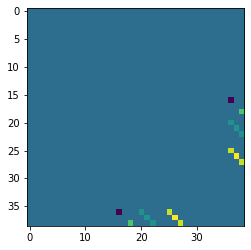

In [19]:
plt.imshow(H_laser_z.real)

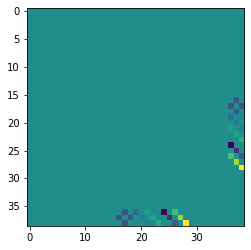

In [20]:
plt.imshow(H_laser_x.real)

In [21]:
%%time
test = optical_coupling_matrix(QN, ground_states_laser, excited_states_laser, pol_vec = np.array([0,0,1]), 
                                reduced = False)
test[np.abs(test) < 1e-3*np.max(np.abs(test))] = 0

Wall time: 41.1 s


In [22]:
print('#'*100)
QN[20].print_state(1e-1)
print('-'*100)
QN[36].print_state(1e-1)
print('#'*100)

####################################################################################################
+0.9983-0.0000j x |X, J = 2, F1 = 3/2, F = 2, mF = -1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
----------------------------------------------------------------------------------------------------
+0.8518+0.0000j x |B, J = 1, F1 = 3/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+0.5233+0.0000j x |B, J = 2, F1 = 3/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
####################################################################################################


In [23]:
print('#'*100)
QN[21].print_state(1e-1)
print('-'*100)
QN[37].print_state(1e-1)
print('#'*100)

####################################################################################################
+0.9983-0.0000j x |X, J = 2, F1 = 3/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
----------------------------------------------------------------------------------------------------
+0.8518+0.0000j x |B, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+0.5233+0.0000j x |B, J = 2, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
####################################################################################################


In [24]:
print('#'*100)
QN[22].print_state(1e-1)
print('-'*100)
QN[38].print_state(1e-1)
print('#'*100)

####################################################################################################
+0.9983-0.0000j x |X, J = 2, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
----------------------------------------------------------------------------------------------------
+0.8518+0.0000j x |B, J = 1, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+0.5233+0.0000j x |B, J = 2, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
####################################################################################################


In [25]:
print('#'*100)
QN[25].print_state(1e-1)
print('-'*100)
QN[36].print_state(1e-1)
print('#'*100)

####################################################################################################
+0.9983+0.0000j x |X, J = 2, F1 = 5/2, F = 2, mF = -1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
----------------------------------------------------------------------------------------------------
+0.8518+0.0000j x |B, J = 1, F1 = 3/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+0.5233+0.0000j x |B, J = 2, F1 = 3/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
####################################################################################################


In [26]:
for idx, idy in zip(*np.nonzero(test)):
    print(f'{idx}, {idy} : {test[idx,idy].real:+.2e}')

16, 36 : -2.24e-01
18, 38 : +2.24e-01
20, 36 : +8.85e-02
21, 37 : +1.02e-01
22, 38 : +8.86e-02
25, 36 : +3.42e-01
26, 37 : +3.94e-01
27, 38 : +3.42e-01
36, 16 : -2.24e-01
36, 20 : +8.85e-02
36, 25 : +3.42e-01
37, 21 : +1.02e-01
37, 26 : +3.94e-01
38, 18 : +2.24e-01
38, 22 : +8.86e-02
38, 27 : +3.42e-01


In [27]:
for idx, idy in zip(*np.nonzero(H_laser_z)):
    print(f'{idx}, {idy} : {H_laser_z[idx,idy].real:+.2e}')

16, 36 : -2.24e-01
18, 38 : +2.24e-01
20, 36 : +8.85e-02
21, 37 : +1.02e-01
22, 38 : +8.86e-02
25, 36 : +3.42e-01
26, 37 : +3.94e-01
27, 38 : +3.42e-01
36, 16 : -2.24e-01
36, 20 : +8.85e-02
36, 25 : +3.42e-01
37, 21 : +1.02e-01
37, 26 : +3.94e-01
38, 18 : +2.24e-01
38, 22 : +8.86e-02
38, 27 : +3.42e-01


In [28]:
for idx, idy in zip(*np.nonzero(H_laser_x)):
    print(f'{idx}, {idy} : {H_laser_x[idx,idy]:+.2e}')

16, 37 : -1.59e-01+0.00e+00j
17, 36 : -1.59e-01+0.00e+00j
17, 38 : -1.59e-01+0.00e+00j
18, 37 : -1.59e-01+0.00e+00j
19, 36 : -8.85e-02+0.00e+00j
20, 37 : -6.26e-02+0.00e+00j
21, 36 : +3.61e-02+0.00e+00j
21, 38 : -3.62e-02+0.00e+00j
22, 37 : +6.26e-02+0.00e+00j
23, 38 : +8.85e-02+0.00e+00j
24, 36 : -3.42e-01+0.00e+00j
25, 37 : -2.42e-01+0.00e+00j
26, 36 : +1.39e-01+0.00e+00j
26, 38 : -1.39e-01+0.00e+00j
27, 37 : +2.42e-01+0.00e+00j
28, 38 : +3.42e-01+0.00e+00j
36, 17 : -1.59e-01+0.00e+00j
36, 19 : -8.85e-02+0.00e+00j
36, 21 : +3.61e-02+0.00e+00j
36, 24 : -3.42e-01+0.00e+00j
36, 26 : +1.39e-01+0.00e+00j
37, 16 : -1.59e-01+0.00e+00j
37, 18 : -1.59e-01+0.00e+00j
37, 20 : -6.26e-02+0.00e+00j
37, 22 : +6.26e-02+0.00e+00j
37, 25 : -2.42e-01+0.00e+00j
37, 27 : +2.42e-01+0.00e+00j
38, 17 : -1.59e-01+0.00e+00j
38, 21 : -3.62e-02+0.00e+00j
38, 23 : +8.85e-02+0.00e+00j
38, 26 : -1.39e-01+0.00e+00j
38, 28 : +3.42e-01+0.00e+00j


In [235]:
# Calculate the matrix element for the "main" transition so that coupling matrix can be scaled to have appropriate rabi rate

# Define approximate form of main ground state
ground_main_approx = 1*CoupledBasisState(J=2,F1=5/2,F=2,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = 1, Omega = 0)
ground_main_i = find_state_idx_from_state(H_X_diag,ground_main_approx, QN_X_diag)
ground_main = QN_X_diag[ground_main_i]

# Define approximate form of main excited state
excited_main_approx = 1*CoupledBasisState(J = 1,F1=3/2,F=1,mF=0,I1=1/2,I2=1/2, electronic_state='B', P = -1, Omega = 1)
excited_main_i = find_state_idx_from_state(H_B_diag,excited_main_approx, QN_B_diag)
excited_main = QN_B_diag[excited_main_i]

ME_main = ED_ME_mixed_state(excited_main, ground_main, pol_vec = np.array([0,0,1]))

In [31]:
def square_wave(t, frequency, phase = 0):
    return 0.5*(1+signal.square(2*np.pi*frequency*t+phase))

In [104]:
import astropy.units as units
import astropy.constants as csts

def calc_D_eff(Gamma, frequency):
    c = csts.c
    e0 = csts.eps0
    hbar = csts.hbar
    Gamma /= units.s
    frequency *= units.Hertz
    return np.sqrt( (Gamma) * 3*np.pi * e0 *hbar * c**3 / (2*np.pi * frequency)**3 ).decompose()

In [120]:
# Calculate effective dipole moment for the optical transitions
Gamma = 1/100e-9 #Natural linewidth in 2*pi*Hz
f = csts.c.value/271.7e-9
D_eff = calc_D_eff(Gamma, f)
D_eff

<Quantity 2.66755059e-30 A m s>

In [264]:
# Oskari uses Hz/(V/cm), assuming [mmomentum] = h/[length]
conv_Ams_to_HzVcm = 1.509e35 * units.Hz/(units.V/units.cm)
D_eff_HzVcm = D_eff.value*conv_Ams_to_HzVcm
D_eff_HzVcm

<Quantity 402533.38377417 cm Hz / V>

In [281]:
import astropy.units as units
import astropy.constants as csts

@units.quantity_input
def calculate_power_needed(Omega: units.Hz, ME, fwhm: units.m, D_TlF: units.Hz/(units.V/units.cm)):
    """
    Function to calculate the power required to get peak Rabi rate Omega
    for a transition with given matrix element with a gaussian spatial profile
    """
    c = csts.c
    epsilon_0 = csts.eps0
    
    #Calculate the electric field required
    E =  Omega/(ME*D_TlF)

    #Convert E to peak intensity
    I = 1/2 * c * epsilon_0 * E**2

    #Convert FWHM to standard deviation
    sigma = fwhm/(2*np.sqrt(2*np.log(2)))

    #Convert power to amplitude of the Gaussian
    P = I * (2*np.pi *sigma**2)

    return P.to(units.W)

In [282]:
calculate_power_needed(4.5*Gamma*units.Hz, ME_main.real, 2.06e-3*units.m, D_eff_HzVcm)

<Quantity 5.12605254 W>

In [283]:
@units.quantity_input
def calculate_power_needed(Omega: units.Hz, ME, fwhm: units.m, D_TlF: units.A*units.s*units.m):
    """
    Function to calculate the power required to get peak Rabi rate Omega
    for a transition with given matrix element with a gaussian spatial profile
    """
    c = csts.c
    epsilon_0 = csts.eps0
    
    #Calculate the electric field required
    E =  Omega*csts.hbar/(ME*D_TlF)

    #Convert E to peak intensity
    I = 1/2 * c * epsilon_0 * E**2

    #Convert FWHM to standard deviation
    sigma = fwhm/(2*np.sqrt(2*np.log(2)))

    #Convert power to amplitude of the Gaussian
    P = I * (2*np.pi *sigma**2)

    return P.to(units.W)

In [284]:
calculate_power_needed(4.5*Gamma*units.Hz, ME_main.real, 2.06e-3*units.m, D_eff)

<Quantity 0.12981171 W>

In [273]:
@units.quantity_input
def calculate_rabi_konrad(power: units.W, diameter: units.m, D_TlF: units.A*units.s*units.m):
    c = csts.c
    hbar = csts.hbar
    eps0 = csts.eps0
    return (D_TlF*np.sqrt(8*power/(np.pi*c*eps0*diameter**2))/hbar).to('Hz')

In [274]:
calculate_rabi_konrad(40*units.mW, 3.5*units.mm, D_eff)

<Quantity 44769659.90522188 Hz>

In [258]:
# Konrads conversion from power to Rabi rate Omega

import scipy.constants as constants
c = constants.c
eps0 = constants.epsilon_0
hbar = constants.hbar
diam_L = 3.5e-3
(constants.elementary_charge*csts.a0*0.32).value * np.sqrt(8*40e-3/(np.pi*c*eps0*diam_L**2))/hbar

45533667.931835055

In [263]:
csts.e.si*csts.a0

<Quantity 8.47835363e-30 C m>

In [174]:
(D_eff*np.sqrt(8*40*units.mW*csts.c*csts.eps0*(3*units.mm)**2)/csts.hbar)

<Quantity 69938.68518087 A F(1/2) m mm mW(1/2) / (J s(1/2))>

In [176]:
4.5*Gamma

45000000.0

In [122]:
# Generate optical coupling matrix with set rabi rate
Omega = 2*np.pi*1000e3 #[2pi*Hz]
Omega = 4.5*Gamma

# Define frequency for polarization switching
omega_p = 1*Gamma
wp = omega_p/(2*np.pi)

H_oc_t = lambda t: -(Omega/ME_main)*(H_laser_z*square_wave(t, wp, 0) + H_laser_x*square_wave(t, wp, np.pi))

H_oc = Omega*H_laser_z/ME_main

In [117]:
D_eff

401893.63828756084

In [27]:
D_eff

401893.63828756084

In [27]:
Omega/Gamma

4.5

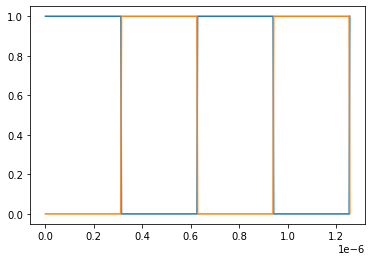

In [28]:
_t = np.linspace(0,2/wp, 501)
plt.plot(_t, square_wave(_t, wp, 0))
plt.plot(_t, square_wave(_t, wp, np.pi))

## Total Hamiltonian

In [29]:
H_X_shifted = H_X_red - H_X_red[ground_main_i,ground_main_i]*np.eye(H_X_red.shape[0])

detuning = 0
H_B_shifted = np.diag(np.diag(H_B_red - H_B_diag[excited_main_i,excited_main_i] + detuning))

In [30]:
_H = np.zeros([39,39], dtype = 'complex')
_H[:36, :36] = H_X_shifted
_H[36:,36:] = H_B_shifted

def Hamiltonian(t):
    return _H + H_oc_t(t)

In [31]:
Hamiltonian(0).shape

(39, 39)

In [32]:
excited_test_approx = 1*CoupledBasisState(J = 1, F1=3/2, F=1, mF=0, I1=1/2, I2=1/2, electronic_state='B', P = -1, Omega = 1)
excited_test_i = find_state_idx_from_state(H_B_diag,excited_test_approx, QN_B_diag)
excited_test = QN_B_diag[excited_test_i]

ground_test_approx = 1*CoupledBasisState(J=0,F1=1/2,F=1,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = 1, Omega = 0)
ground_test_i = find_state_idx_from_state(H_X_diag,ground_test_approx, QN_X_diag)
ground_test = QN_X_diag[ground_test_i]

BRs = calculate_BR(excited_test, ground_states)

In [33]:
C_array = collapse_matrices(QN, ground_states, excited_states, gamma = Gamma)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

## Density Matrix

In [34]:
# Define states that are populated initially
Js = [0,1,2]
states_pop_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
              for J  in Js
              for F1 in ni_range(np.abs(J-I_Tl),J+I_Tl+1)
              for F in ni_range(np.abs(F1-I_F),F1+I_F+1)
              for mF in ni_range(-F, F+1)
             ]

states_pop = []
for state in states_pop_approx:
    i = find_state_idx_from_state(H_X_diag,state, QN_X_diag)
    states_pop.append(QN_X_diag[i])
    
pops = np.ones(len(states_pop))/len(states_pop)

rho_ini = generate_density_matrix(QN,states_pop,pops)

In [35]:
import scipy.constants as cst

def boltzmann_distribution(rot_constant, temperature, J_list):
    init = np.zeros(len(J_list))
    Z = 0
    g = 1
    for J in J_list:
        g = 4*(2*J+1)
        Z += g*np.exp(-rot_constant*J*(J+1)*2*np.pi*cst.hbar/(temperature*cst.k))
    for idx, J in enumerate(J_list):
        g = 4*(2*J+1)
        init[idx] = g*np.exp(-rot_constant*J*(J+1)*2*np.pi*cst.hbar/(temperature*cst.k))/Z
    return init

In [36]:
B_0 = 6.68667*1e9 # Hz
T = 7
boltz_dist = boltzmann_distribution(B_0,T, np.arange(0,150,1))

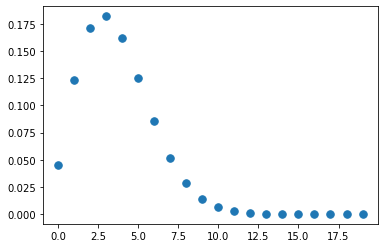

In [37]:
plt.plot(boltz_dist[:20], '.', ms = 15)

In [38]:
def get_J_indices(J_list):
    spans = []
    for J in J_list:
        spans.append(4*(2*J+1))
    indices = [(0,spans[0])]
    for idx,span in enumerate(spans[1:]):
        s = np.sum(spans[:idx+1])
        indices.append((s, s+span))
    return indices

In [39]:
for idx, (idx_min, idx_max) in enumerate(get_J_indices([0,1,2])):
    sl = np.s_[idx_min:idx_max, idx_min:idx_max]
    print(idx, idx_max-idx_min, boltz_dist[idx]/(idx_max-idx_min))
    np.fill_diagonal(rho_ini[sl], boltz_dist[idx]/(idx_max-idx_min))
rho_ini /= np.diag(rho_ini).sum()

0 4 0.011286978903789161
1 12 0.01029811954327005
2 20 0.008572714492675116


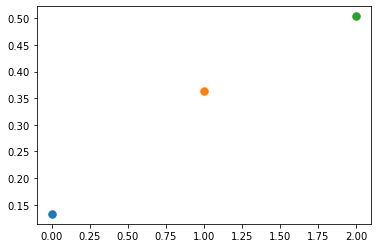

In [40]:
for idx, (idx_min, idx_max) in enumerate(get_J_indices([0,1,2])):
    sl = np.s_[idx_min:idx_max, idx_min:idx_max]
    plt.plot(idx, np.sum(np.diag(rho_ini[sl])).real, '.', ms = 15)

## Speed testing some optimizations for Lindblad_rhs

In [41]:
# generate a random
# _x = rho_ini
_x = np.random.random(rho_ini.shape).astype('complex')
opt = 'greedy'

In [42]:
%%timeit
np.einsum('ijk,kl,ilm',C_array, _x, C_conj_array,optimize = opt)

1.66 ms ± 41.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [43]:
%%timeit
np.einsum('ijk,kl,ilm',C_array, _x, C_conj_array)

271 ms ± 6.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
# precalculating the optimum multiplication path
path = np.einsum_path('ijk,kl,ilm',C_array, _x, C_conj_array, optimize='optimal')[0]

In [45]:
%%timeit
np.einsum('ijk,kl,ilm',C_array, _x, C_conj_array,optimize = path)

1.57 ms ± 97.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [46]:
# naive replacement using numba
from numba import njit

@njit
def multi_faster(result, C, C_conj, rho):
    r1 = C.shape[0]
    r2 = C.shape[1]
    
    for j in range(r2):
        for m in range(r2):
            for i in range(r1):
                for k in range(r2):
                    for l in range(r2):
                        result[j,m] += C[i,j,k]*rho[k,l]*C_conj[i,l,m]

In [47]:
%%timeit
# naive replacement using numba
result = np.zeros(_x.shape, dtype = 'complex')
multi_faster(result, C_array, C_conj_array, _x)

128 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
%%timeit
# replace einsum with a for loop and matrix product
# fastest for Jmax > 2
s = np.zeros(rho_ini.shape, dtype = 'complex')
for idx in range(C_array.shape[0]):
    s += C_array[idx]@_x@C_conj_array[idx]

754 µs ± 25.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [49]:
%%timeit
# replace einsum with a matrix mult and sum
(C_array@_x@C_conj_array).sum(axis = 0)

523 µs ± 57.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [50]:
%%timeit
# replace einsum with a matrix mult and einsum
# fastest for Jmax <= 2
np.einsum('ijk->jk',C_array@_x@C_conj_array)

485 µs ± 39.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [51]:
# replace einsum witha numba @njit function
result = np.zeros(_x.shape, dtype = 'complex')
multi_faster(result, C_array, C_conj_array, _x)
np.array_equal(result, np.einsum('ijk,kl,ilm',C_array, _x, C_conj_array))

True

In [52]:
# replace einsum with a for loop
s = np.zeros(rho_ini.shape, dtype = 'complex')
for idx in range(C_array.shape[0]):
    s += C_array[idx]@_x@C_conj_array[idx]
np.array_equal(np.einsum('ijk,kl,ilm',C_array, _x, C_conj_array), s)

True

In [53]:
# replace einsum with a matrix mult and sum
np.array_equal(np.einsum('ijk,kl,ilm',C_array, _x, C_conj_array), (C_array@_x@C_conj_array).sum(axis = 0))

True

In [54]:
# replace einsum with a matrix mult and einsum
np.array_equal(np.einsum('ijk->jk',C_array@_x@C_conj_array), np.einsum('ijk,kl,ilm',C_array, _x, C_conj_array))

True

In [55]:
%%timeit
np.einsum('ijk,ikl,lm', C_conj_array, C_array, _x, optimize = opt)

298 µs ± 26 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [56]:
Cprecalc = np.einsum('ijk,ikl', C_conj_array, C_array)

In [57]:
%%timeit
Cprecalc@_x

8.01 µs ± 517 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [58]:
# not the same result
print(np.array_equal(np.einsum('ijk,ikl,lm', C_conj_array, C_array, _x), Cprecalc@_x))
print(np.array_equal(np.einsum('jk,ikl,ilm', _x, C_conj_array, C_array), _x@Cprecalc))

False
False


In [59]:
# but within 1e-8, well within rounding error
print(np.all(np.isclose(np.einsum('ijk,ikl,lm', C_conj_array, C_array, _x), Cprecalc@_x, 1e-8)))
print(np.all(np.isclose(np.einsum('jk,ikl,ilm', _x, C_conj_array, C_array), _x@Cprecalc, 1e-8)))

True
True


## ODE Solver

In [60]:
Cprecalc = np.einsum('ijk,ikl', C_conj_array, C_array)

#Define the rhs of the Lindblad equation
def Lindblad_rhs(t, rho_vec):
    dim = int(np.sqrt(len(rho_vec)))
    rho = rho_vec.reshape((dim,dim))
    
    _s = np.zeros(rho_ini.shape, dtype = 'complex')
    for idx in range(C_array.shape[0]):
        _s[:,:] += C_array[idx]@rho@C_conj_array[idx]
        
    rhs = (-1j* (Hamiltonian(t) @ rho - rho @ Hamiltonian(t)) + 
           _s
           -0.5 * (Cprecalc@rho + rho@Cprecalc)).flatten()
    return rhs

In [61]:
%%time
from scipy.integrate import solve_ivp

#Generate rho vector
rho_vec = rho_ini.flatten()

T = 100e-6

t_span = (0, T)

step_size = min(1/(Gamma/(2*np.pi))/5, 1/omega_p/5, 1/(Omega/(2*np.pi))/5)
step_size = 1e-6
print(f'step_size : {step_size:.2e}')

sol = solve_ivp(Lindblad_rhs, t_span, rho_vec, dense_output=True, max_step = step_size, vectorized = True)

step_size : 1.00e-06
Wall time: 29.7 s


In [62]:
pop_results = np.real(np.einsum('jji->ji',sol.y.reshape((rho_ini.shape[0], rho_ini.shape[1], sol.y.shape[1]))))

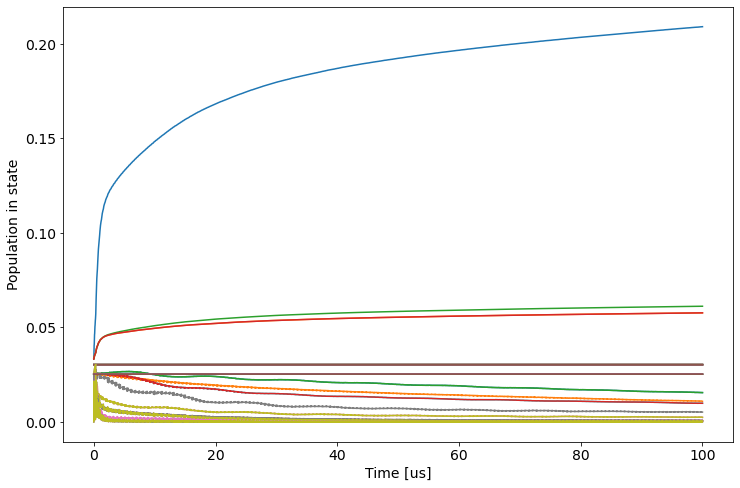

In [63]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(sol.t*1e6, pop_results.T)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

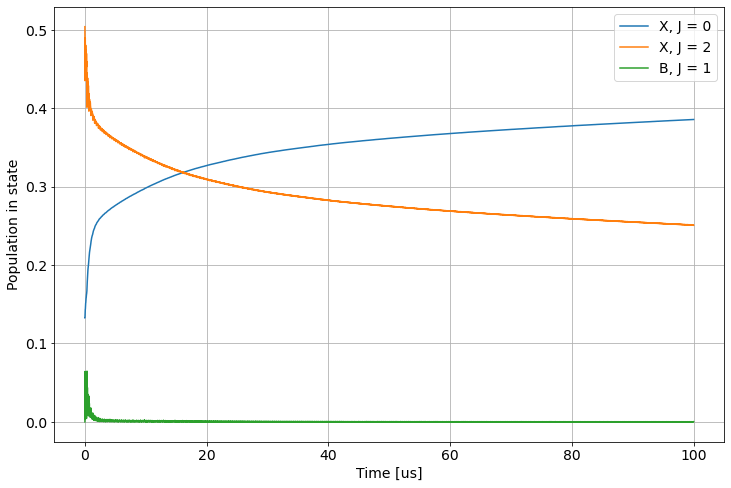

In [64]:
pop_results = np.real(np.einsum('jji->ji',sol.y.reshape((rho_ini.shape[0], rho_ini.shape[1], sol.y.shape[1]))))

t_array = sol.t

m = t_array <= 300e-6

t_array = t_array[m]
pop_results = pop_results[:,m]

#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
PB1 = np.sum(pop_results[36:,:], axis = 0)

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
# ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)

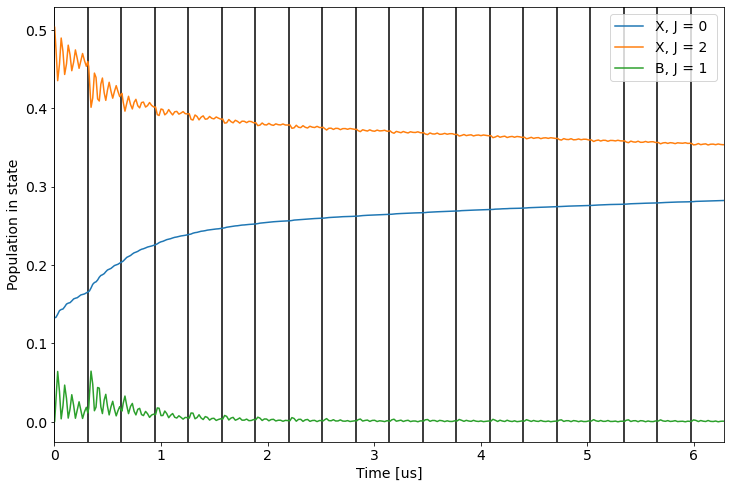

In [65]:
fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1 ')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlim(0,10e6/wp)
for i in range(20):
    ax.axvline(i*1e6/wp/2, zorder = 0, color = 'k')

In [66]:
print(P0_triplet[-1]/P0_triplet[0])
print(P0_singlet[-1]/P0_singlet[0])
print(P0[-1]/P0[0])

1.7735289461538908
6.302681792974527
2.9058171578590497


In [67]:
from tqdm import tqdm

solutions = {}
for factor in tqdm([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5]):
    #Generate optical coupling matrix with set rabi rate
    Omega = factor*Gamma

    #Define frequency for polarization switching
    omega_p = 1*Gamma
    wp = omega_p/(2*np.pi)
    H_oc_t = lambda t: (Omega/ME_main)*(H_laser_z*square_wave(t, wp, 0) + H_laser_x*square_wave(t, wp, np.pi))

    def Hamiltonian(t):
        return _H + H_oc_t(t)
    
    #Define the rhs of the Lindblad equation
    def Lindblad_rhs(t, rho_vec):
        dim = int(np.sqrt(len(rho_vec)))
        rho = rho_vec.reshape((dim,dim))

        _s = np.zeros(rho_ini.shape, dtype = 'complex')
        for idx in range(C_array.shape[0]):
            _s[:,:] += C_array[idx]@rho@C_conj_array[idx]

        rhs = (-1j* (Hamiltonian(t) @ rho - rho @ Hamiltonian(t)) + 
               _s
               -0.5 * (Cprecalc@rho + rho@Cprecalc)).flatten()
        return rhs
    
    #Generate rho vector
    rho_vec = rho_ini.flatten()

    T = 100e-6

    t_span = (0, T)
    t_step = min(1/wp/5, 1/(Gamma/(2*np.pi))/5,1e-8)
    
    sol = solve_ivp(Lindblad_rhs, t_span, rho_vec, dense_output=True, max_step = t_step, vectorized = True)
    solutions[factor] = sol

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [15:34<00:00, 103.81s/it]


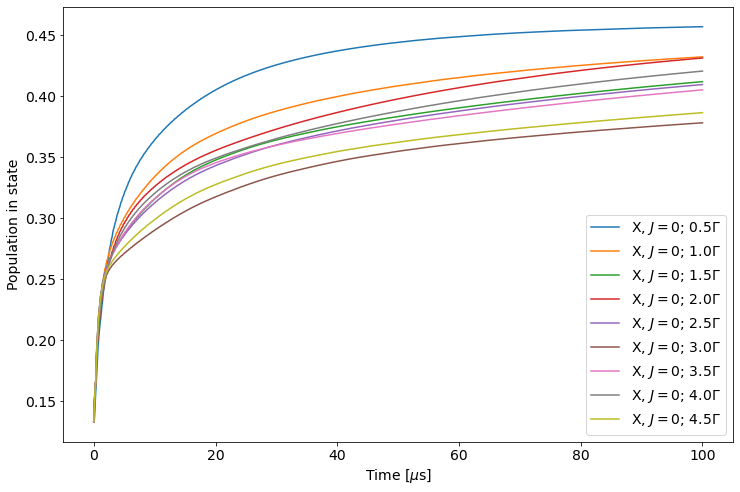

In [68]:
fig, ax = plt.subplots(figsize = (12,8))


for factor, sol in solutions.items():
    s1,s2 = int(np.sqrt(sol.y.shape[0])), sol.y.shape[1]
    pop_results = np.real(np.einsum('jji->ji',sol.y.reshape((s1,s1, s2))))
    t_array = sol.t
    
    #Plot populations in different J
    P0 = np.sum(pop_results[:4], axis = 0)

    ax.plot(t_array*1e6, P0, label = f'X, $J = 0$; {factor:.1f}$\Gamma$')
    
ax.legend(fontsize = 14)
ax.set_xlabel(r"Time [$\mu$s]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

(0.0, 12.566370614359172)

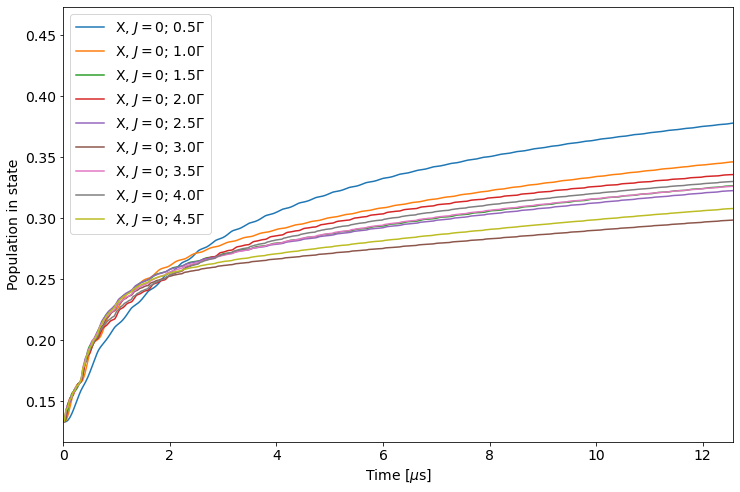

In [69]:
fig, ax = plt.subplots(figsize = (12,8))


for factor, sol in solutions.items():
    s1,s2 = int(np.sqrt(sol.y.shape[0])), sol.y.shape[1]
    pop_results = np.real(np.einsum('jji->ji',sol.y.reshape((s1,s1, s2))))
    t_array = sol.t
    
    #Plot populations in different J
    P0 = np.sum(pop_results[:4], axis = 0)

    ax.plot(t_array*1e6, P0, label = f'X, $J = 0$; {factor:.1f}$\Gamma$')
    
ax.legend(fontsize = 14)
ax.set_xlabel(r"Time [$\mu$s]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

ax.set_xlim(0,20e6/wp)

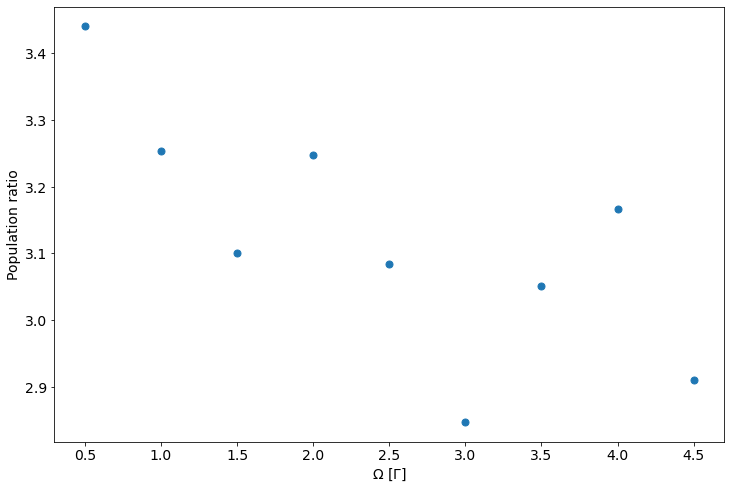

In [70]:
fig, ax = plt.subplots(figsize = (12,8))

for factor, sol in solutions.items():
    s1,s2 = int(np.sqrt(sol.y.shape[0])), sol.y.shape[1]
    pop_results = np.real(np.einsum('jji->ji',sol.y.reshape((s1,s1, s2))))
    t_array = sol.t

    P0 = np.sum(pop_results[:4], axis = 0)

    ax.plot(factor, P0[-1]/P0[0], '.', ms = 14, color = 'C0')
    
ax.set_xlabel(r"$\Omega$ [$\Gamma$]", fontsize = 14)
ax.set_ylabel("Population ratio", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

## Scan $\Omega$

In [71]:
from tqdm import tqdm

solutions = {}
for factor in tqdm(np.arange(0.2, 3.2, 0.2)):
    #Generate optical coupling matrix with set rabi rate
    Omega = factor*Gamma

    #Define frequency for polarization switching
    omega_p = 1*Gamma
    wp = omega_p/(2*np.pi)
    H_oc_t = lambda t: (Omega/ME_main)*(H_laser_z*square_wave(t, wp, 0) + H_laser_x*square_wave(t, wp, np.pi))
    # H_oc_t = lambda t: (Omega/ME_main)*H_laser_z*np.cos(omega_p*t) + H_laser_x*np.sin(omega_p*t)

    def Hamiltonian(t):
        return _H + H_oc_t(t)
    
    #Define the rhs of the Lindblad equation
    def Lindblad_rhs(t, rho_vec):
        dim = int(np.sqrt(len(rho_vec)))
        rho = rho_vec.reshape((dim,dim))

        _s = np.zeros(rho_ini.shape, dtype = 'complex')
        for idx in range(C_array.shape[0]):
            _s[:,:] += C_array[idx]@rho@C_conj_array[idx]

        rhs = (-1j* (Hamiltonian(t) @ rho - rho @ Hamiltonian(t)) + 
               _s
               -0.5 * (Cprecalc@rho + rho@Cprecalc)).flatten()
        return rhs
    
    #Generate rho vector
    rho_vec = rho_ini.flatten()

    T = 240e-6

    t_span = (0, T)
    t_step = min(1/wp/5, 1/(Gamma/(2*np.pi))/5)
    
    sol = solve_ivp(Lindblad_rhs, t_span, rho_vec, dense_output=True, max_step = t_step, vectorized = True)
    solutions[factor] = sol

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [08:37<00:00, 34.51s/it]


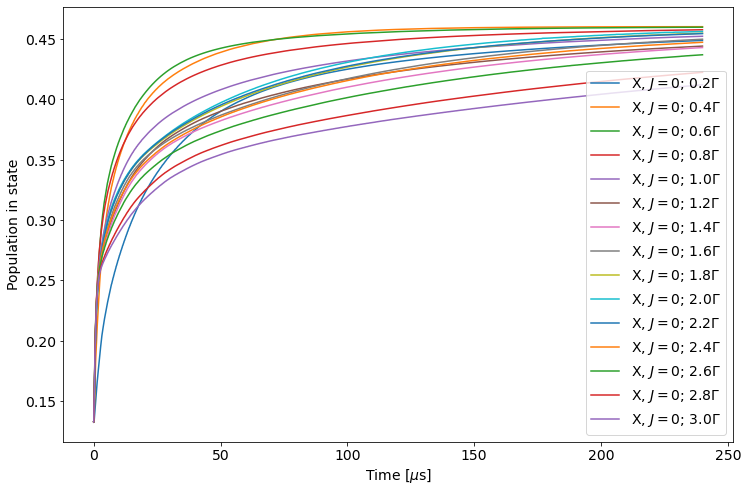

In [72]:
fig, ax = plt.subplots(figsize = (12,8))


for factor, sol in solutions.items():
    s1,s2 = int(np.sqrt(sol.y.shape[0])), sol.y.shape[1]
    pop_results = np.real(np.einsum('jji->ji',sol.y.reshape((s1,s1, s2))))
    t_array = sol.t
    
    #Plot populations in different J
    P0 = np.sum(pop_results[:4], axis = 0)

    ax.plot(t_array*1e6, P0, label = f'X, $J = 0$; {factor:.1f}$\Gamma$')
    
ax.legend(fontsize = 14)
ax.set_xlabel(r"Time [$\mu$s]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

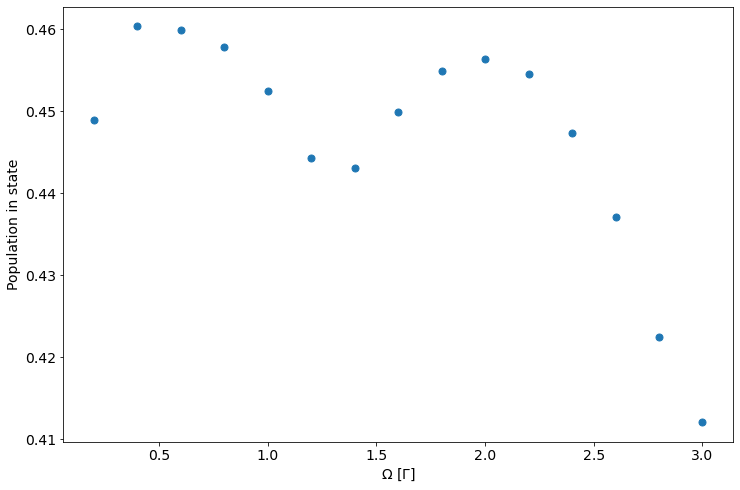

In [73]:
fig, ax = plt.subplots(figsize = (12,8))

for factor, sol in solutions.items():
    s1,s2 = int(np.sqrt(sol.y.shape[0])), sol.y.shape[1]
    pop_results = np.real(np.einsum('jji->ji',sol.y.reshape((s1,s1, s2))))
    t_array = sol.t
    
    #Plot populations in different J
    P0 = np.sum(pop_results[:4], axis = 0)

    ax.plot(factor, P0[-1], '.', ms = 14, color = 'C0')
    
ax.set_xlabel(r"$\Omega$ [$\Gamma$]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

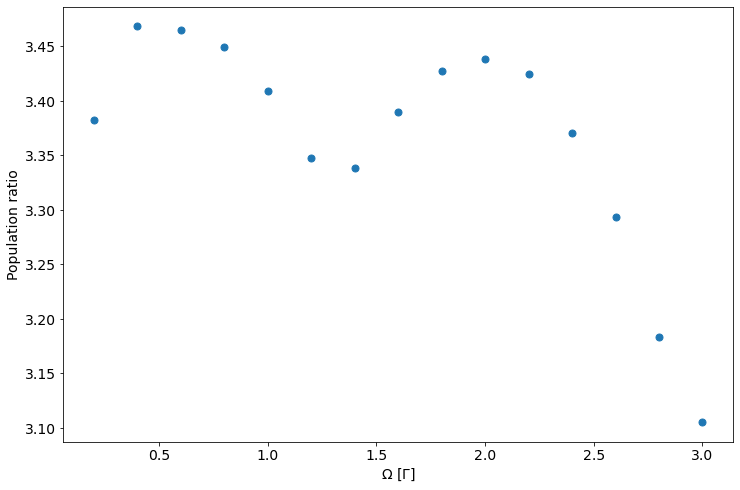

In [74]:
fig, ax = plt.subplots(figsize = (12,8))

for factor, sol in solutions.items():
    s1,s2 = int(np.sqrt(sol.y.shape[0])), sol.y.shape[1]
    pop_results = np.real(np.einsum('jji->ji',sol.y.reshape((s1,s1, s2))))
    t_array = sol.t

    P0 = np.sum(pop_results[:4], axis = 0)

    ax.plot(factor, P0[-1]/P0[0], '.', ms = 14, color = 'C0')
    
ax.set_xlabel(r"$\Omega$ [$\Gamma$]", fontsize = 14)
ax.set_ylabel("Population ratio", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

## Resonant Polarization Modulation

In [75]:
#Calculate effective dipole moment for the optical transitions
Gamma = 1/100e-9 #Natural linewidth in 2*pi*Hz
f = 3e8/271.7e-9 #Frequency in Hz
D_eff = (np.sqrt(3*np.pi*8.85e-12*1.05e-34*3e8**3*Gamma/(2*np.pi*f)**3)
         /(1/3e8 * 1e-21)* 0.393430307 * 5.291772e-9/4.135667e-15)  #Hz/(V/cm)

#Generate optical coupling matrix with set rabi rate
Omega = 2*np.pi*1000e3 #[2pi*Hz]

#Define frequency for polarization switching
omega_p = 4.5*Gamma

wp = omega_p/(2*np.pi)
H_oc_t = lambda t: (Omega/ME_main)*(H_laser_z *(1+np.cos(omega_p*t))/2 + H_laser_x*(1-np.cos(omega_p*t))/2)

H_oc = Omega*H_laser_z/ME_main

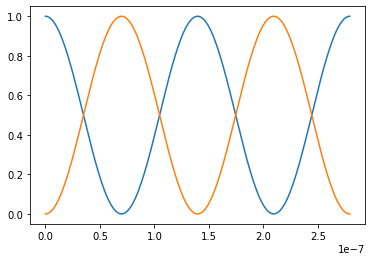

In [76]:
_t = np.linspace(0,2/wp,201)
plt.plot(_t, (1+np.cos(omega_p*_t))/2)
plt.plot(_t, (1-np.cos(omega_p*_t))/2)

In [77]:
H_X_shifted = H_X_red - H_X_red[ground_main_i,ground_main_i]*np.eye(H_X_red.shape[0])

detuning = 0
H_B_shifted = np.diag(np.diag(H_B_red - H_B_diag[excited_main_i,excited_main_i] + detuning))

_H = np.zeros([39,39], dtype = 'complex')
_H[:36, :36] = H_X_shifted
_H[36:,36:] = H_B_shifted

def Hamiltonian(t):
    return _H + H_oc_t(t)

In [78]:
#Define the rhs of the Lindblad equation
def Lindblad_rhs(t, rho_vec):
    dim = int(np.sqrt(len(rho_vec)))
    rho = rho_vec.reshape((dim,dim))

    _s = np.zeros(rho_ini.shape, dtype = 'complex')
    for idx in range(C_array.shape[0]):
        _s[:,:] += C_array[idx]@rho@C_conj_array[idx]

    rhs = (-1j* (Hamiltonian(t) @ rho - rho @ Hamiltonian(t)) + 
           _s
           -0.5 * (Cprecalc@rho + rho@Cprecalc)).flatten()
    return rhs

In [79]:
%%time
from scipy.integrate import solve_ivp

#Generate rho vector
rho_vec = rho_ini.flatten()

T = 100e-6

t_span = (0, T)
step_size = min(1/wp/5, 1/(Gamma/(2*np.pi))/5)
print(f'tstep : {t_step:.2e}')

sol = solve_ivp(Lindblad_rhs, t_span, rho_vec, dense_output=False, max_step = step_size, vectorized = True)

tstep : 1.26e-07
Wall time: 34.5 s


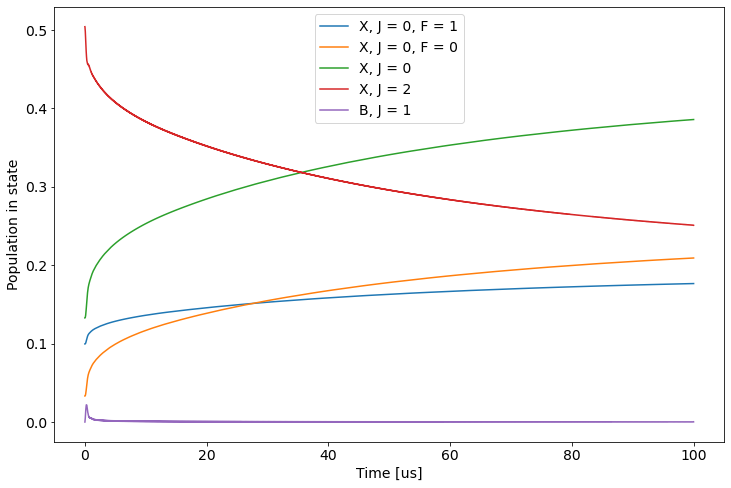

In [80]:
pop_results = np.real(np.einsum('jji->ji',sol.y.reshape((rho_ini.shape[0], rho_ini.shape[1], sol.y.shape[1]))))

t_array = sol.t
#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
PB1 = np.sum(pop_results[36:,:], axis = 0)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
# ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

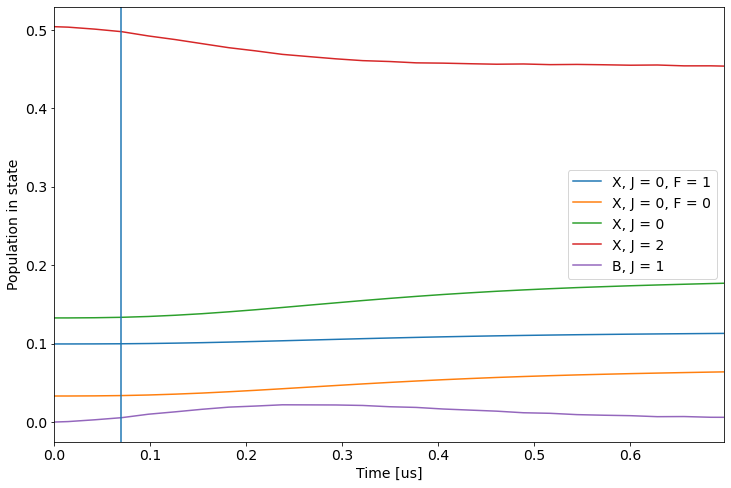

In [81]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
# ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
# ax.plot(t_array*1e6, P3, label = 'X, J = 3')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlim(0,5e6/wp)
ax.axvline(1e6/wp/2)
# for ti in t_array[:50]*1e6:
#     ax.axvline(ti, color = 'k', zorder = 0)

In [82]:
print(P0_triplet[-1]/P0_triplet[0])
print(P0_singlet[-1]/P0_singlet[0])
print(P0[-1]/P0[0])

1.7735122626336346
6.30256743183209
2.9057760549332485
